In [429]:
import pandas as pd
import numpy as np

# Operating System
import os

# https requests
import requests

import matplotlib.pyplot as plt
%matplotlib inline

# World Population  

[This UN source](https://data.un.org/Data.aspx?d=PopDiv&f=variableID%3a12%3btimeID%3a83%2c84%3bvarID%3a2&c=2,4,6,7&s=_crEngNameOrderBy:asc,_timeEngNameOrderBy:desc,_varEngNameOrderBy:asc&v=1#PopDiv) was used.

In [216]:
filename = "./data/UNdata_Export_20200324_225732447.csv"

# read csv data file into a DataFrame
df_population = pd.read_csv(filename)

# Tidy the data and keep just the values we will need
df_population.columns = ['country', 'year', 'variant', 'million_people']
df_population['million_people'] = df_population['million_people']/1000
df_population['country'] = df_population['country'].str.lower()
df_population = df_population.loc[df_population.year == 2019]
df_population = df_population.drop(columns=['year', 'variant'])
df_population = df_population.drop_duplicates()
df_population = df_population.reset_index(drop=True)

# change country names to match the COVID database
replacement_dict = {'bolivia (plurinational state of)':'bolivia',
                    'iran (islamic republic of)':'iran',
                    'republic of korea':'korea, south' ,
                    'russian federation':'russia' ,
                    'syrian arab republic':'syria' ,
                    'united states of america':'us' ,
                    'venezuela (bolivarian republic of)':'venezuela' ,
                    'viet nam':'vietnam'}

df_population['country'] = df_population['country'].replace(to_replace=replacement_dict)

# validate no duplicate values
assert df_population.country.duplicated().sum() == 0

df_population = df_population.set_index('country').sort_index()

In [217]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
Index: 282 entries, afghanistan to zimbabwe
Data columns (total 1 columns):
million_people    282 non-null float64
dtypes: float64(1)
memory usage: 4.4+ KB


In [218]:
df_population.head()

million_people
country                       
afghanistan          38.041754
africa             1308.064195
albania               2.880917
algeria              43.053054
american samoa        0.055312

In [517]:
df_population.to_pickle('./data/df_population.pkl')

# Import the COVID data

### Data Sources  


* https://github.com/datasets/covid-19
* https://github.com/CSSEGISandData/COVID-19
* https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [105]:
# We will be using the first data source

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
r = requests.get(url)

filename = "./data/covid_panel_data_aggregation.csv"

f = open(filename, "w") 
f.write(r.text) 
f.close()

# read csv data file into a DataFrame
df_original = pd.read_csv(filename)

In [106]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15680 entries, 0 to 15679
Data columns (total 8 columns):
Date              15680 non-null object
Country/Region    15680 non-null object
Province/State    4736 non-null object
Lat               15680 non-null float64
Long              15680 non-null float64
Confirmed         15680 non-null int64
Recovered         14074 non-null float64
Deaths            15680 non-null int64
dtypes: float64(3), int64(2), object(3)
memory usage: 980.1+ KB


### confirm if database has been updated

In [107]:
df_original.tail()

Date         Country/Region Province/State        Lat       Long  \
15675  2020-03-21  Saint Kitts and Nevis            NaN  17.357822 -62.782998   
15676  2020-03-22  Saint Kitts and Nevis            NaN  17.357822 -62.782998   
15677  2020-03-23  Saint Kitts and Nevis            NaN  17.357822 -62.782998   
15678  2020-03-24  Saint Kitts and Nevis            NaN  17.357822 -62.782998   
15679  2020-03-25  Saint Kitts and Nevis            NaN  17.357822 -62.782998   

       Confirmed  Recovered  Deaths  
15675          0        NaN       0  
15676          0        NaN       0  
15677          0        NaN       0  
15678          0        NaN       0  
15679          2        NaN       0

### Buid main DataFrame

In [533]:
# Tidy DataFrame

def tidy_df(df_original, df_population=None):
    
    df_tidy = df_original.copy()
    
    # drop rows in which any of the values we will use is NaN
    df_tidy = df_tidy.dropna(how='any', subset=['Confirmed', 'Deaths'])
    
    # simplify 'Country/Region' and Province/State'    
    df_tidy = df_tidy.rename(columns = {'Country/Region': 'country',
                                        'Province/State': 'state',
                                        'Confirmed': 'total_infections',
                                        'Deaths': 'total_deaths'
                                       })
    
    # conver column names to lower case
    df_tidy.columns = df_tidy.columns.str.lower()
    
    # Convert Date from string to datetime
    df_tidy["date"] = pd.to_datetime(df_tidy.date)
    
    # Convert string values to lower case
    df_tidy['country'] = df_tidy.country.str.lower()
    df_tidy['state'] = df_tidy.state.str.lower()
    
    # Fill string nans with ''
    df_tidy['state'] = df_tidy.state.fillna('')
    
    # If country equals the state (e.g., france, united kingdom, us,...) remove the state
    df_tidy.loc[df_tidy.country==df_tidy.state, 'state'] = ""
    
    
    # Merge COVID with population DataFrames    
    # df_tidy = pd.merge(df_tidy, df_population, how='inner', on='country', validate='many_to_one')
    
    
    # Set new index
    df_tidy = df_tidy.set_index(keys=['country', 'state', 'date']).sort_index()
    
    # Build variables to use afterward
#     df_tidy['currently infected'] = df_tidy['confirmed'] - df_tidy['recovered']    
#     df_tidy['currently infected increase'] = df_tidy['currently infected'].diff()
#     df_tidy['deaths increase'] = df_tidy['deaths'].diff()
#     df_tidy['new_infections_growth_rate'] = df_tidy['new_infections'].pct_change().mul(100)
    
    df_tidy['new_infections'] = df_tidy['total_infections'].diff()
    df_tidy['new_infections_increase'] = df_tidy['new_infections'].diff()  
    
    df_tidy['new_deaths'] = df_tidy['total_deaths'].diff()
    
    df_tidy = df_tidy[['lat', 'long', 'total_infections', 'new_infections', 'new_infections_increase', 'recovered', 'total_deaths', 'new_deaths']]
    
    return df_tidy


In [534]:
df_main = tidy_df(df_original)

In [535]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15680 entries, (afghanistan, , 2020-01-22 00:00:00) to (zimbabwe, , 2020-03-25 00:00:00)
Data columns (total 8 columns):
lat                        15680 non-null float64
long                       15680 non-null float64
total_infections           15680 non-null int64
new_infections             15679 non-null float64
new_infections_increase    15678 non-null float64
recovered                  14074 non-null float64
total_deaths               15680 non-null int64
new_deaths                 15679 non-null float64
dtypes: float64(6), int64(2)
memory usage: 1.0+ MB


In [536]:
# df_main.index.get_level_values('state').drop_duplicates()

In [537]:
df_main.loc[idx["portugal", :,"2020-03-03":], :]

lat    long  total_infections  new_infections  \
country  state date                                                            
portugal       2020-03-03  39.3999 -8.2245                 2             0.0   
               2020-03-04  39.3999 -8.2245                 5             3.0   
               2020-03-05  39.3999 -8.2245                 8             3.0   
               2020-03-06  39.3999 -8.2245                13             5.0   
               2020-03-07  39.3999 -8.2245                20             7.0   
               2020-03-08  39.3999 -8.2245                30            10.0   
               2020-03-09  39.3999 -8.2245                30             0.0   
               2020-03-10  39.3999 -8.2245                41            11.0   
               2020-03-11  39.3999 -8.2245                59            18.0   
               2020-03-12  39.3999 -8.2245                59             0.0   
               2020-03-13  39.3999 -8.2245               112            53.0   
               2020-03-14  39.3999 -8.2245               169            57.0   
               2020-03-15  39.3999 -8.2245               245            76.0   
               2020-03-16  39.3999 -8.2245               331            86.0   
               2020-03-17  39.3999 -8.2245               448           117.0   
               2020-03-18  39.3999 -8.2245               448             0.0   
               2020-03-19  39.3999 -8.2245               785           337.0   
               2020-03-20  39.3999 -8.2245              1020           235.0   
               2020-03-21  39.3999 -8.2245              1280           260.0   
               2020-03-22  39.3999 -8.2245              1600           320.0   
               2020-03-23  39.3999 -8.2245              2060           460.0   
               2020-03-24  39.3999 -8.2245              2362           302.0   
               2020-03-25  39.3999 -8.2245              2995           633.0   

                           new_infections_increase  recovered  total_deaths  \
country  state date                                                           
portugal       2020-03-03                     -2.0        0.0             0   
               2020-03-04                      3.0        0.0             0   
               2020-03-05                      0.0        0.0             0   
               2020-03-06                      2.0        0.0             0   
               2020-03-07                      2.0        0.0             0   
               2020-03-08                      3.0        0.0             0   
               2020-03-09                    -10.0        0.0             0   
               2020-03-10                     11.0        0.0             0   
               2020-03-11                      7.0        0.0             0   
               2020-03-12                    -18.0        0.0             0   
               2020-03-13                     53.0        1.0             0   
               2020-03-14                      4.0        2.0             0   
               2020-03-15                     19.0        2.0             0   
               2020-03-16                     10.0        3.0             0   
               2020-03-17                     31.0        3.0             1   
               2020-03-18                   -117.0        3.0             2   
               2020-03-19                    337.0        3.0             3   
               2020-03-20                   -102.0        5.0             6   
               2020-03-21                     25.0        5.0            12   
               2020-03-22                     60.0        5.0            14   
               2020-03-23                    140.0        5.0            23   
               2020-03-24                   -158.0        NaN            33   
               2020-03-25                    331.0        NaN            43   

                           new_deaths  
country  state

In [538]:
df_main.to_pickle('./data/df_main.pkl')

# FINISH HERE!

# Today picture

In [515]:
last_date = df_main.index.get_level_values('date').max()
df_world_today = df_main.loc[idx[:, :,last_date], :].sum()
df_world_today

lat                             5352.208547
long                            6228.330379
confirmed                     467593.000000
new_infections                 49548.000000
new_infections_increase         9738.000000
new_infections_growth_rate              NaN
recovered                          0.000000
deaths                         21180.000000
new_deaths                      2555.000000
dtype: float64

In [514]:
str_to_print = "On {} there were {:,.0f} new infections reported worldwide, an increase of {:,.0f} new infections from the previous day."
format_parameters_list = [last_date.strftime("%d-%b-%Y"), 
                          df_world_today['new_infections'],
                          df_world_today['new_infections_increase']
                         ]

print(str_to_print.format(*format_parameters_list))

On 25-Mar-2020 there were 49,548 new infections reported worldwide, an increase of 9,738 new infections from the previous day.


### Build today country-level DataFrame

In [449]:
def build_single_day_df(df_main, day_to_use=None):

    # Create new DataFrame for country-level analysis
    df_today = df_main.copy()
    
    # Aggregate suming the values for different states
    df_today = df_today.groupby(level = ['country', 'date']).sum().sort_index()

    # Drop unused columns
    df_today = df_today.drop(columns=['lat', 'long'])
    
    # Keep a signle date in the dataframe
    if day_to_use is None:
        last_date = df_today.index.get_level_values('date').max()
    else:
        last_date = day_to_use

    idx = pd.IndexSlice
    df_today = df_today.loc[idx[:,last_date], :]    
    
    return df_today


In [456]:
df_today = build_single_day_df(df_main)

#df_today[df_today.confirmed>1000]
df_today.loc[idx["portual":"russia",:],:]

confirmed  new_infections  new_infections_increase  \
country  date                                                             
portugal 2020-03-25       2995           633.0                    331.0   
qatar    2020-03-25        537            11.0                    -14.0   
romania  2020-03-25        906           112.0                   -106.0   
russia   2020-03-25        658           163.0                    106.0   

                     recovered  deaths  new_deaths  
country  date                                       
portugal 2020-03-25        0.0      43        10.0  
qatar    2020-03-25        0.0       0         0.0  
romania  2020-03-25        0.0      17         6.0  
russia   2020-03-25        0.0       3         2.0

### Merge with country population

In [228]:
# df_aux = pd.merge(df_today, df_population, how='left', on='country', validate='one_to_one')
# df_aux

In [439]:
def plot_today_figures(df_today, var_to_plot, pop=None, num_countries=10, min_pop = 1):
    
    df_plot = df_today[[var_to_plot]].copy()
    
    # save the last date and drop date index
    last_date_str = df_plot.index.get_level_values('date').max().strftime("%d-%b-%Y") 
    df_plot = df_plot.reset_index(level='date', drop=True)
    
    if pop is not None:
        
        # validade population DataFrame
        assert isinstance(pop, pd.DataFrame)
        assert pop.index.name == 'country'
        assert 'million_people' in pop.columns
        
        # merge with COVID DataFrame
        df_plot = pd.merge(df_plot, pop, how='inner', on='country', validate='one_to_one')
        
        # Create variable to plot formatted with correct units
        df_plot['plot_this'] = df_plot[var_to_plot] / df_plot['million_people']
        
        # Drop countries with less than min_pop population
        df_plot = df_plot.loc[df_plot.million_people > min_pop,:]
        
    else:
        df_plot['plot_this'] = df_plot[var_to_plot]

    
    
    # select top countries
    top_list = df_plot.loc[:, 'plot_this'].sort_values(ascending=False).iloc[:num_countries].index.tolist()
    
    if "portugal" not in top_list:
        top_list.append("portugal")
    
    # Format plot title
    plot_title_str = '{} on {}'.format(var_to_plot, last_date_str).replace('_', ' ').capitalize()
    if 'increase' in plot_title_str:
        plot_title_str += ' from previous day value' 
    
    # Format ylabel
    if pop is not None:
        y_lab = 'per million people'
    else:
        y_lab = 'total'
    
    # Format plot file name
    file_name_str = var_to_plot + '_' + y_lab.replace(' ', '_')
    
    # Plot
    df_plot.loc[top_list, ['plot_this']].plot.bar(figsize=(8,4))
    
    plt.grid(axis='y')
    plt.legend('')

    plt.title(plot_title_str)
    plt.ylabel('[{}]'.format(y_lab))
    plt.xticks(rotation=25)
    
    plt.savefig(os.path.join('plots', file_name_str));

    
    return df_plot, top_list

new_infections_increase_per_million_people


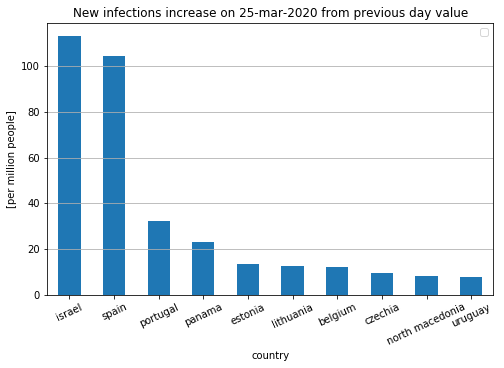

In [440]:
df_aux, top_list = plot_today_figures(df_today, 'new_infections_increase', pop=df_population)

new_infections_total
new_infections_increase_total


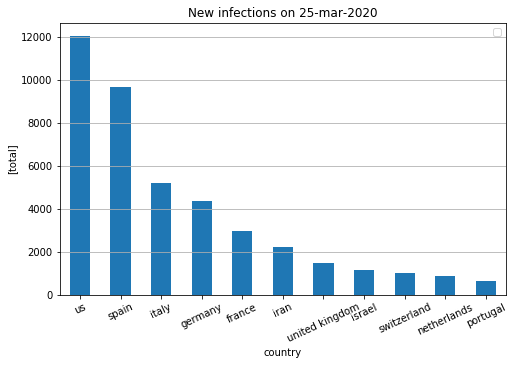

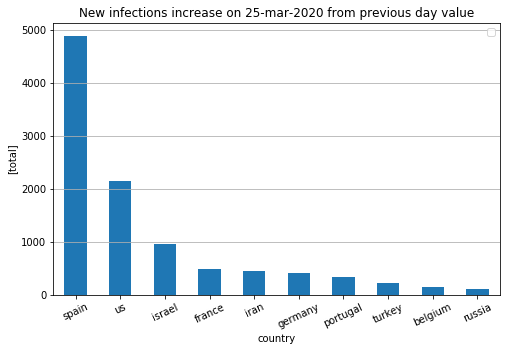

In [458]:
for var_to_plot in ['new_infections', 'new_infections_increase']:
    plot_today_figures(df_today, var_to_plot, pop=None)

In [389]:
df_aux.sort_values(by='plot_this',ascending=False)

new_infections  million_people   plot_this
country                                                             
spain                             9630.0       46.736776  206.047589
israel                            1131.0        8.519377  132.756186
switzerland                       1020.0        8.591365  118.723858
italy                             5210.0       60.550075   86.044485
portugal                           633.0       10.226187   61.899905
belgium                            668.0       11.539328   57.888986
germany                           4337.0       83.517045   51.929519
netherlands                        858.0       17.097130   50.183861
ireland                            235.0        4.882495   48.131130
france                            2978.0       65.129728   45.724128
norway                             221.0        5.378857   41.086796
us                               12038.0      329.064917   36.582447
austria                            305.0        8.955102   34.058797
iran                              2206.0       82.913906   26.605911
estonia                             35.0        1.325648   26.402182
denmark                            144.0        5.771876   24.948561
czechia                            260.0       10.689209   24.323596
sweden                             240.0       10.036379   23.913007
lithuania                           65.0        2.759627   23.553908
slovenia                            48.0        2.078654   23.091866
panama                              98.0        4.246439   23.078160
united kingdom                    1476.0       67.530172   21.856897
bahrain                             27.0        1.641172   16.451658
finland                             88.0        5.532156   15.906999
croatia                             60.0        4.130304   14.526776
north macedonia                     29.0        2.083459   13.919160
australia                          320.0       25.203198   12.696801
latvia                              24.0        1.906743   12.586909
singapore                           73.0        5.804337   12.576802
canada                             461.0       37.411047   12.322563
...                                  ...             ...         ...
vietnam                              7.0       96.462106    0.072567
mozambique                           2.0       30.366036    0.065863
kenya                                3.0       52.573973    0.057062
china                               70.0     1433.783686    0.048822
nepal                                1.0       28.608710    0.034954
nigeria                              7.0      200.963599    0.034832
chad                                 0.0       15.946876    0.000000
papua new guinea                     0.0        8.776109    0.000000
benin                                0.0       11.801151    0.000000
central african republic             0.0        4.745185    0.000000
eswatini                             0.0        1.148130    0.000000
bangladesh                           0.0      163.046161    0.000000
argentina                            0.0       44.780677    0.000000
angola                               0.0       31.825295    0.000000
equatorial guinea                    0.0        1.355986    0.000000
sudan                                0.0       42.813238    0.000000
ethiopia                             0.0      112.078730    0.000000
timor-leste                          0.0        1.293119    0.000000
gabon                                0.0        2.172579    0.000000
gambia                               0.0        2.347706    0.000000
sri lanka                            0.0       21.323733    0.000000
guinea                               0.0       12.771246    0.000000
somalia                              0.0       15.442905    0.000000
liberia                              0.0        4.937374    0.000000
libya                                0.0        6.777452    0.000000
mauritania              

In [351]:
df_aux.loc[top_list, var_to_plot]

country
us                12038.0
spain              9630.0
italy              5210.0
germany            4337.0
france             2978.0
iran               2206.0
united kingdom     1476.0
israel             1131.0
switzerland        1020.0
netherlands         858.0
portugal            633.0
Name: new_infections, dtype: float64

In [354]:
df_aux.loc[:, ['new_infections']].div(df_aux.million_people)

afghanistan  albania  algeria  andorra  angola  \
country                                                                    
afghanistan                       NaN      NaN      NaN      NaN     NaN   
albania                           NaN      NaN      NaN      NaN     NaN   
algeria                           NaN      NaN      NaN      NaN     NaN   
andorra                           NaN      NaN      NaN      NaN     NaN   
angola                            NaN      NaN      NaN      NaN     NaN   
antigua and barbuda               NaN      NaN      NaN      NaN     NaN   
argentina                         NaN      NaN      NaN      NaN     NaN   
armenia                           NaN      NaN      NaN      NaN     NaN   
australia                         NaN      NaN      NaN      NaN     NaN   
austria                           NaN      NaN      NaN      NaN     NaN   
azerbaijan                        NaN      NaN      NaN      NaN     NaN   
bahamas                           NaN      NaN      NaN      NaN     NaN   
bahrain                           NaN      NaN      NaN      NaN     NaN   
bangladesh                        NaN      NaN      NaN      NaN     NaN   
barbados                          NaN      NaN      NaN      NaN     NaN   
belarus                           NaN      NaN      NaN      NaN     NaN   
belgium                           NaN      NaN      NaN      NaN     NaN   
belize                            NaN      NaN      NaN      NaN     NaN   
benin                             NaN      NaN      NaN      NaN     NaN   
bhutan                            NaN      NaN      NaN      NaN     NaN   
bolivia                           NaN      NaN      NaN      NaN     NaN   
bosnia and herzegovina            NaN      NaN      NaN      NaN     NaN   
brazil                            NaN      NaN      NaN      NaN     NaN   
bulgaria                          NaN      NaN      NaN      NaN     NaN   
burkina faso                      NaN      NaN      NaN      NaN     NaN   
cabo verde                        NaN      NaN      NaN      NaN     NaN   
cambodia                          NaN      NaN      NaN      NaN     NaN   
cameroon                          NaN      NaN      NaN      NaN     NaN   
canada                            NaN      NaN      NaN      NaN     NaN   
central african republic          NaN      NaN      NaN      NaN     NaN   
...                               ...      ...      ...      ...     ...   
seychelles                        NaN      NaN      NaN      NaN     NaN   
singapore                         NaN      NaN      NaN      NaN     NaN   
slovakia                          NaN      NaN      NaN      NaN     NaN   
slovenia                          NaN      NaN      NaN      NaN     NaN   
somalia                           NaN      NaN      NaN      NaN     NaN   
south africa                      NaN      NaN      NaN      NaN     NaN   
spain                             NaN      NaN      NaN      NaN     NaN   
sri lanka                         NaN      NaN      NaN      NaN     NaN   
sudan                             NaN      NaN      NaN      NaN     NaN   
suriname                          NaN      NaN      NaN      NaN     NaN   
sweden                            NaN      NaN      NaN      NaN     NaN   
switzerland                       NaN      NaN      NaN      NaN     NaN   
syria                             NaN      NaN      NaN      NaN     NaN   
thailand                          NaN      NaN      NaN      NaN     NaN   
timor-leste                       NaN      NaN      NaN      NaN     NaN   
togo                              NaN      NaN      NaN      NaN     NaN   
trinidad and tobago               NaN      NaN      NaN      NaN     NaN   
tunisia                           NaN      NaN      NaN      NaN     NaN   
turkey                            NaN      NaN      NaN      NaN     NaN   
uganda                            NaN      NaN      NaN      NaN     NaN  

In [327]:
isinstance(df_aux, pd.DataFrame)

True

In [331]:
df_population.index.name == 'country'

True

In [ ]:
cs_countries.loc[top_list].to_frame().plot.bar(figsize=(8,4))

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases on {}'.format(data_format, variable, last_date.strftime("%d-%b-%Y")))
plt.ylabel('');

In [ ]:
# Select cross section of countries
cs_countries = df_today.groupby('country')[variable].sum()

### Choose variable

In [629]:
# choose variable: confirmed, recovered, deaths
variable = "confirmed"

### Choose data format

In [630]:
# choose data format: total or new
data_format = "new"

---

In [631]:
# Confirm aceptable value for variable
assert variable in ['confirmed', 'recovered', 'deaths']

# Confirm acceptable value for data_format
assert data_format in ['total', 'new']

In [633]:
# If analysis of new cases compute difference from previous day
if data_format == "new":
    df_today.loc[:,['confirmed', 'recovered', 'deaths']] = df_today.loc[:,['confirmed', 'recovered', 'deaths']].diff(periods=1)
    

In [634]:
# select last available date
last_date = df.date.drop_duplicates().sort_values().iloc[-1]
last_date

Timestamp('2020-03-23 00:00:00')

In [635]:
df_today = df_today.loc[df_today.date == last_date,: ].reset_index(drop=True)
df_today = df_today.loc[:, ['date', 'country', 'confirmed', 'recovered', 'deaths']]

In [636]:
# Select cross section of countries
cs_countries = df_today.groupby('country')[variable].sum()

In [637]:
# select top-level countries plus portugal
top_number = 10
top_list = cs_countries.sort_values(ascending=False).iloc[:top_number].index.tolist()

if "portugal" not in top_list:
    top_list.append("portugal")

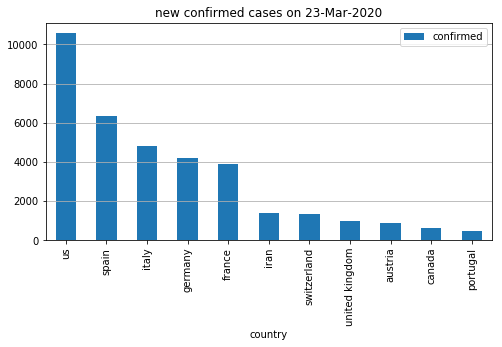

In [638]:
cs_countries.loc[top_list].to_frame().plot.bar(figsize=(8,4))

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases on {}'.format(data_format, variable, last_date.strftime("%d-%b-%Y")))
plt.ylabel('');

In [639]:
df_today

date                 country  confirmed  recovered  deaths
0   2020-03-23             afghanistan        0.0        0.0     0.0
1   2020-03-23                 albania       15.0        0.0     2.0
2   2020-03-23                 algeria       29.0        0.0     0.0
3   2020-03-23                 andorra       20.0        0.0     0.0
4   2020-03-23                  angola        1.0        0.0     0.0
5   2020-03-23     antigua and barbuda        2.0        0.0     0.0
6   2020-03-23               argentina       35.0        0.0     0.0
7   2020-03-23                 armenia       41.0        0.0     0.0
8   2020-03-23               australia       13.0        0.0     0.0
9   2020-03-23               australia        0.0        0.0     0.0
10  2020-03-23               australia        0.0        0.0     0.0
11  2020-03-23               australia       60.0        0.0     0.0
12  2020-03-23               australia       34.0        0.0     0.0
13  2020-03-23               australia        6.0        0.0     0.0
14  2020-03-23               australia        0.0        0.0     0.0
15  2020-03-23               australia       20.0        0.0     0.0
16  2020-03-23                 austria      892.0        0.0     5.0
17  2020-03-23              azerbaijan        7.0        0.0     0.0
18  2020-03-23                 bahamas        0.0        NaN     0.0
19  2020-03-23                 bahrain       43.0        0.0     0.0
20  2020-03-23              bangladesh        6.0        0.0     1.0
21  2020-03-23                barbados        3.0        0.0     0.0
22  2020-03-23                 belarus        5.0        0.0     0.0
23  2020-03-23                 belgium      342.0        0.0    13.0
24  2020-03-23                  belize        1.0        NaN     0.0
25  2020-03-23                   benin        3.0        0.0     0.0
26  2020-03-23                  bhutan        0.0        0.0     0.0
27  2020-03-23                 bolivia        3.0        0.0     0.0
28  2020-03-23  bosnia and herzegovina       10.0        0.0     0.0
29  2020-03-23                  brazil      378.0        0.0     9.0
..         ...                     ...        ...        ...     ...
208 2020-03-23                   sudan        0.0        0.0     0.0
209 2020-03-23                suriname        0.0        0.0     0.0
210 2020-03-23                  sweden      112.0        0.0     4.0
211 2020-03-23             switzerland     1321.0        0.0    22.0
212 2020-03-23                   syria        0.0        0.0     0.0
213 2020-03-23                 taiwan*       26.0        0.0     0.0
214 2020-03-23                tanzania        0.0        0.0     0.0
215 2020-03-23                thailand      122.0        0.0     0.0
216 2020-03-23             timor-leste        0.0        0.0     0.0
217 2020-03-23                    togo        2.0        0.0     0.0
218 2020-03-23     trinidad and tobago        1.0        0.0     0.0
219 2020-03-23                 tunisia       14.0        0.0     0.0
220 2020-03-23                  turkey      293.0        0.0     7.0
221 2020-03-23                  uganda        8.0        0.0     0.0
222 2020-03-23                 ukraine        0.0        0.0     0.0
223 2020-03-23    united arab emirates       45.0        0.0     0.0
224 2020-03-23          united kingdom      967.0        NaN    54.0
225 2020-03-23          united kingdom        0.0        0.0     0.0
226 2020-03-23          united kingdom        2.0        0.0     0.0
227 2020-03-23          united kingdom        4.0        0.0     0.0
228 2020-03-23          united kingdom        0.0        0.0     0.0
229 2020-03-23          united kingdom        8.0        0.0     0.0
230 2020-03-23          united kingdom        0.0        0.0     0.0
231 2020-03-23                 uruguay        4.0        0.0     0.0
232 2020-03-23                      us    10571.0        NaN   140.0
233 2020-03-23              uzbekistan        3.0        0.0     0.0
234 2020

In [642]:
pd.merge(df_today, df_population, how='left', on='country', validate='many_to_one')

date                 country  confirmed  recovered  deaths    year  \
0   2020-03-23             afghanistan        0.0        0.0     0.0  2019.0   
1   2020-03-23                 albania       15.0        0.0     2.0  2019.0   
2   2020-03-23                 algeria       29.0        0.0     0.0  2019.0   
3   2020-03-23                 andorra       20.0        0.0     0.0  2019.0   
4   2020-03-23                  angola        1.0        0.0     0.0  2019.0   
5   2020-03-23     antigua and barbuda        2.0        0.0     0.0  2019.0   
6   2020-03-23               argentina       35.0        0.0     0.0  2019.0   
7   2020-03-23                 armenia       41.0        0.0     0.0  2019.0   
8   2020-03-23               australia       13.0        0.0     0.0  2019.0   
9   2020-03-23               australia        0.0        0.0     0.0  2019.0   
10  2020-03-23               australia        0.0        0.0     0.0  2019.0   
11  2020-03-23               australia       60.0        0.0     0.0  2019.0   
12  2020-03-23               australia       34.0        0.0     0.0  2019.0   
13  2020-03-23               australia        6.0        0.0     0.0  2019.0   
14  2020-03-23               australia        0.0        0.0     0.0  2019.0   
15  2020-03-23               australia       20.0        0.0     0.0  2019.0   
16  2020-03-23                 austria      892.0        0.0     5.0  2019.0   
17  2020-03-23              azerbaijan        7.0        0.0     0.0  2019.0   
18  2020-03-23                 bahamas        0.0        NaN     0.0  2019.0   
19  2020-03-23                 bahrain       43.0        0.0     0.0  2019.0   
20  2020-03-23              bangladesh        6.0        0.0     1.0  2019.0   
21  2020-03-23                barbados        3.0        0.0     0.0  2019.0   
22  2020-03-23                 belarus        5.0        0.0     0.0  2019.0   
23  2020-03-23                 belgium      342.0        0.0    13.0  2019.0   
24  2020-03-23                  belize        1.0        NaN     0.0  2019.0   
25  2020-03-23                   benin        3.0        0.0     0.0  2019.0   
26  2020-03-23                  bhutan        0.0        0.0     0.0  2019.0   
27  2020-03-23                 bolivia        3.0        0.0     0.0     NaN   
28  2020-03-23  bosnia and herzegovina       10.0        0.0     0.0  2019.0   
29  2020-03-23                  brazil      378.0        0.0     9.0  2019.0   
..         ...                     ...        ...        ...     ...     ...   
208 2020-03-23                   sudan        0.0        0.0     0.0  2019.0   
209 2020-03-23                suriname        0.0        0.0     0.0  2019.0   
210 2020-03-23                  sweden      112.0        0.0     4.0  2019.0   
211 2020-03-23             switzerland     1321.0        0.0    22.0  2019.0   
212 2020-03-23                   syria        0.0        0.0     0.0     NaN   
213 2020-03-23                 taiwan*       26.0        0.0     0.0     NaN   
214 2020-03-23                tanzania        0.0        0.0     0.0     NaN   
215 2020-03-23                thailand      122.0        0.0     0.0  2019.0   
216 2020-03-23             timor-leste        0.0        0.0     0.0  2019.0   
217 2020-03-23                    togo        2.0        0.0     0.0  2019.0   
218 2020-03-23     trinidad and tobago        1.0        0.0     0.0  2019.0   
219 2020-03-23                 tunisia       14.0        0.0     0.0  2019.0   
220 2020-03-23                  turkey      293.0        0.0     7.0  2019.0   
221 2020-03-23                  uganda        8.0        0.0     0.0  2019.0   
222 2020-03-23                 ukraine        0.0        0.0     0.0  2019.0   
223 2020-03-23    united arab emirates       45.0        0.0     0.0  2019.0   
224 2020-03-23          united kingdom      967.0        NaN    54.0  2019.0   
225 2020-03-23          united kingdom        0.0        0.0     0.0  2019.0   
226 2020-0

2

In [ ]:
pd.merge(df_clean, df_hospitais_codes, how='left', on='clean_name', validate='many_to_one')

---

# Single country analysis - time series

### Choose country, state

In [549]:
# choose country
country = "spain"

# choose state
state = ""

### Choose variable

In [550]:
# choose variable: confirmed, recovered, deaths
variable = "confirmed"

### Choose data format

In [551]:
# choose data format: total or new
data_format = "new"

---

In [552]:
# Confirm aceptable values for country and state
assert country in df.country.values
assert state in df.loc[df.country==country].state.values

# Confirm aceptable value for variable
assert variable in ['confirmed', 'recovered', 'deaths']

# Confirm acceptable value for data_format
assert data_format in ['total', 'new']

In [553]:
# same DataFrame but only for one country
df_country = df.loc[(df.country==country) & (df.state==state)].reset_index(drop = True).sort_values(by='date')

# confirm that we have only one observation per day
assert df_country.date.duplicated().sum() == 0

# set data as DataFrame index
df_country = df_country.set_index('date')

In [555]:
# drop values before the number of comfirmed cases exceeds a minimum number of cases (min_num_cases)
min_num_cases = 1000

first_date = df_country['confirmed'].loc[df_country['confirmed'] > min_num_cases].index[0]
#first_date

In [556]:
if data_format == "new":
    df_country.loc[:,['confirmed', 'recovered', 'deaths']] = df_country.loc[:,['confirmed', 'recovered', 'deaths']].diff(periods=1)
    

### time-trend plot

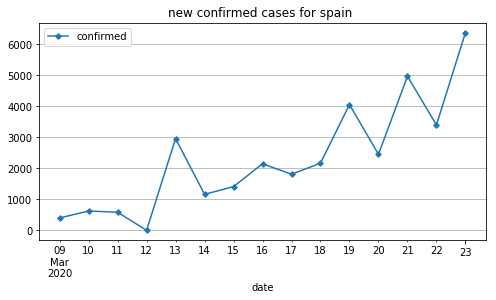

In [557]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {}'.format(data_format, variable, country, state))
plt.ylabel('');

### time-trend plot (log scale)

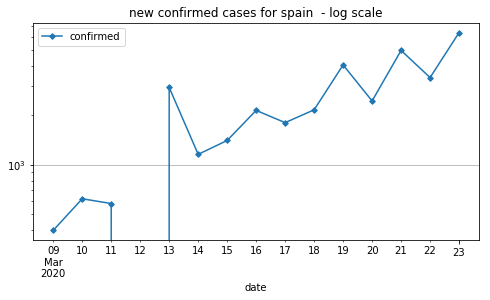

In [559]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].plot(marker='D', markersize=4, logy=True)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - log scale'.format(data_format, variable, country, state))
plt.ylabel('');

### daily growth rate

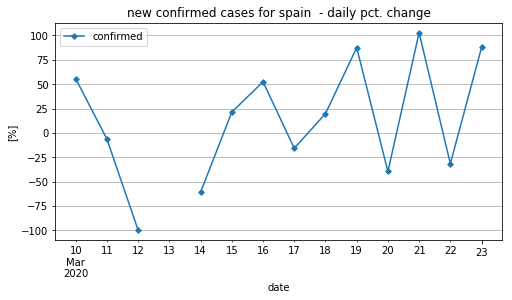

In [560]:
plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].pct_change().multiply(100).plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - daily pct. change'.format(data_format, variable, country, state))
plt.ylabel('[%]');

### daily growth rate - rolling mean

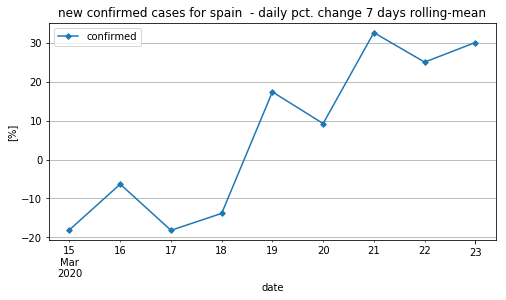

In [561]:
num_days = 7

plt.figure(figsize=(8,4))
df_country[variable].loc[first_date:].pct_change().multiply(100).rolling(num_days, min_periods=num_days-2).mean().plot(marker='D', markersize=4)

plt.grid(axis='y')
plt.legend()

plt.title('{} {} cases for {} {} - daily pct. change {} days rolling-mean'.format(data_format, variable, country, state, num_days))
#plt.title('Daily pct. change of {} cases for {} {} - {} days rolling-mean'.format(variable, country, state, num_days))
plt.ylabel('[%]');


---

### Nº of days to double cases

In [241]:
daily_growth = 0.05

In [242]:
num_days_to_double = (np.log(2))/(np.log(1+daily_growth))
num_days_to_double

14.206699082890463

In [94]:
x =np.arange(0,30,1)
y = 1000*(1+0.1)**x

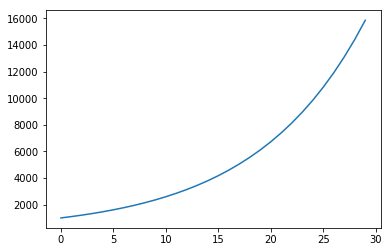

In [95]:
plt.plot(x, y);

In [97]:
ys = pd.Series(y)

In [98]:
ys.pct_change()

0     NaN
1     0.1
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
25    0.1
26    0.1
27    0.1
28    0.1
29    0.1
dtype: float64

In [99]:
ys.diff().pct_change()

0     NaN
1     NaN
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
25    0.1
26    0.1
27    0.1
28    0.1
29    0.1
dtype: float64

In [587]:
ys.diff().pct_change()

0     NaN
1     NaN
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
25    0.1
26    0.1
27    0.1
28    0.1
29    0.1
dtype: float64

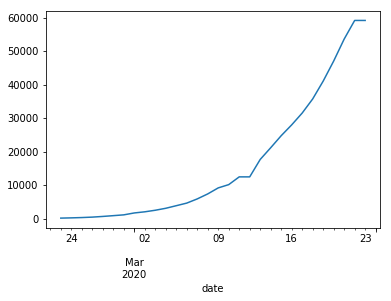

In [10]:
s.plot()

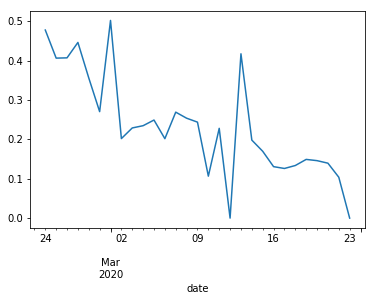

In [11]:
s.pct_change().plot()

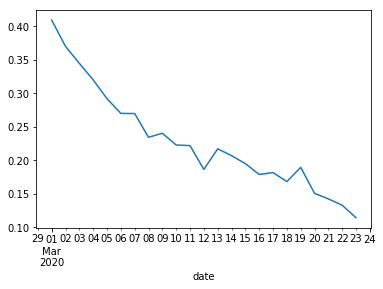

In [12]:
s.pct_change().rolling(7).mean().plot()

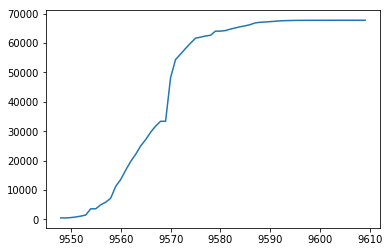

In [13]:
df.loc[(df.country=="China") & (df.state=="Hubei"),:].confirmed.plot()